In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
import pandas as pd
import os, shutil
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:

original_dir = "/content/drive/MyDrive/plantvillage/color"
split_dir    = "/content/drive/MyDrive/PlantVillage_split"

train_dir = f"{split_dir}/train"
test_dir  = f"{split_dir}/test"


if os.path.exists(split_dir):
    shutil.rmtree(split_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(original_dir)

for cls in classes:
    class_path = os.path.join(original_dir, cls)
    if not os.path.isdir(class_path):
        continue

    imgs = os.listdir(class_path)
    imgs = [os.path.join(class_path, img) for img in imgs]

    train_imgs, test_imgs = train_test_split(imgs, test_size=0.2, random_state=42)

    os.makedirs(f"{train_dir}/{cls}", exist_ok=True)
    os.makedirs(f"{test_dir}/{cls}", exist_ok=True)

    for img in train_imgs:
        shutil.copy(img, f"{train_dir}/{cls}")

    for img in test_imgs:
        shutil.copy(img, f"{test_dir}/{cls}")

print("TRAIN/TEST SPLIT DONE!")


TRAIN/TEST SPLIT DONE!


In [ ]:

data_dir = split_dir


train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir + "/train", transform=train_transform)
test_dataset  = datasets.ImageFolder(root=data_dir + "/test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [ ]:
def extract_patches(img, n_patches=4):
    B, C, H, W = img.shape
    p_h, p_w = H//n_patches, W//n_patches
    patches = img.unfold(2,p_h,p_h).unfold(3,p_w,p_w)
    patches = patches.contiguous().view(B,C,-1,p_h,p_w)
    patches = patches.permute(0,2,1,3,4)
    return patches

In [ ]:
class PatchAttention(nn.Module):
    def __init__(self, channels):
        super(PatchAttention,self).__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(channels,channels//2,1),
            nn.ReLU(),
            nn.Conv2d(channels//2,channels,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return x*self.attn(x)

In [ ]:
class PatchCNN(nn.Module):
    def __init__(self):
        super(PatchCNN,self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.ReLU(),
            PatchAttention(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            PatchAttention(64),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        return self.block(x)

In [ ]:
class PatchBasedLeafNet(nn.Module):
    def __init__(self, num_classes, patch_division_factor=4):
        super(PatchBasedLeafNet, self).__init__()
        self.patch_division_factor = patch_division_factor
        self.total_patches = patch_division_factor * patch_division_factor

        self.patch_cnn = PatchCNN()


        original_patch_size = 128 // self.patch_division_factor
        final_feature_map_size = original_patch_size // 4
        self.flattened_single_patch_feature_size = 64 * final_feature_map_size * final_feature_map_size

        self.fc_input_size = self.flattened_single_patch_feature_size * self.total_patches

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        self.feature_maps = None

    def forward(self, x):
        patches = extract_patches(x, n_patches=self.patch_division_factor)
        B, NP, C, H, W = patches.shape
        patch_features = []
        for i in range(NP):
            out = self.patch_cnn(patches[:, i])
            if i == 0:
                self.feature_maps = out
            out = out.view(B, -1)
            patch_features.append(out)
        fused = torch.cat(patch_features, dim=1)
        return self.fc(fused)

In [ ]:

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0,0
    for img,lbl in loader:
        img,lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out,lbl)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1)==lbl).sum().item()
    return total_loss/len(loader), correct/len(loader.dataset)

def test_model(model, loader, criterion):
    model.eval()
    total_loss, correct = 0,0
    y_true,y_pred = [],[]
    with torch.no_grad():
        for img,lbl in loader:
            img,lbl = img.to(device), lbl.to(device)
            out = model(img)
            loss = criterion(out,lbl)
            total_loss += loss.item()
            preds = out.argmax(1)
            correct += (preds==lbl).sum().item()
            y_true.extend(lbl.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return total_loss/len(loader), correct/len(loader.dataset), y_true, y_pred

In [ ]:
model = PatchBasedLeafNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

EPOCHS = 20
train_accs,test_accs=[],[]
train_losses,test_losses=[],[]

for ep in range(EPOCHS):
    tr_loss,tr_acc = train_one_epoch(model,train_loader,criterion,optimizer)
    ts_loss,ts_acc,y_true,y_pred = test_model(model,test_loader,criterion)
    train_accs.append(tr_acc)
    test_accs.append(ts_acc)
    train_losses.append(tr_loss)
    test_losses.append(ts_loss)
    print(f"Epoch {ep+1}/{EPOCHS}  Train Loss:{tr_loss:.3f}  Train Acc:{tr_acc:.3f}  Test Loss:{ts_loss:.3f}  Test Acc:{ts_acc:.3f}")

Epoch 1/20  Train Loss:1.362  Train Acc:0.615  Test Loss:0.716  Test Acc:0.783
Epoch 2/20  Train Loss:0.701  Train Acc:0.787  Test Loss:0.464  Test Acc:0.861
Epoch 3/20  Train Loss:0.527  Train Acc:0.838  Test Loss:0.382  Test Acc:0.889
Epoch 4/20  Train Loss:0.433  Train Acc:0.862  Test Loss:0.307  Test Acc:0.910
Epoch 5/20  Train Loss:0.370  Train Acc:0.882  Test Loss:0.291  Test Acc:0.913
Epoch 6/20  Train Loss:0.324  Train Acc:0.894  Test Loss:0.244  Test Acc:0.928
Epoch 7/20  Train Loss:0.286  Train Acc:0.908  Test Loss:0.233  Test Acc:0.932
Epoch 8/20  Train Loss:0.257  Train Acc:0.916  Test Loss:0.187  Test Acc:0.949
Epoch 9/20  Train Loss:0.236  Train Acc:0.924  Test Loss:0.186  Test Acc:0.951
Epoch 10/20  Train Loss:0.213  Train Acc:0.931  Test Loss:0.182  Test Acc:0.948
Epoch 11/20  Train Loss:0.196  Train Acc:0.935  Test Loss:0.176  Test Acc:0.950
Epoch 12/20  Train Loss:0.181  Train Acc:0.941  Test Loss:0.173  Test Acc:0.951
Epoch 13/20  Train Loss:0.170  Train Acc:0.944  T


Classification Report Table:

                                                    precision    recall  \
Apple___Apple_scab                                   0.949153  0.888889   
Apple___Black_rot                                    0.945312  0.968000   
Apple___Cedar_apple_rust                             0.938776  0.836364   
Apple___healthy                                      0.963415  0.960486   
Blueberry___healthy                                  0.964401  0.990033   
Cherry_(including_sour)___Powdery_mildew             0.990521  0.990521   
Cherry_(including_sour)___healthy                    0.965714  0.988304   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.913978  0.825243   
Corn_(maize)___Common_rust_                          0.995708  0.970711   
Corn_(maize)___Northern_Leaf_Blight                  0.926108  0.954315   
Corn_(maize)___healthy                               0.987288  1.000000   
Grape___Black_rot                                    0.884615  0.9745

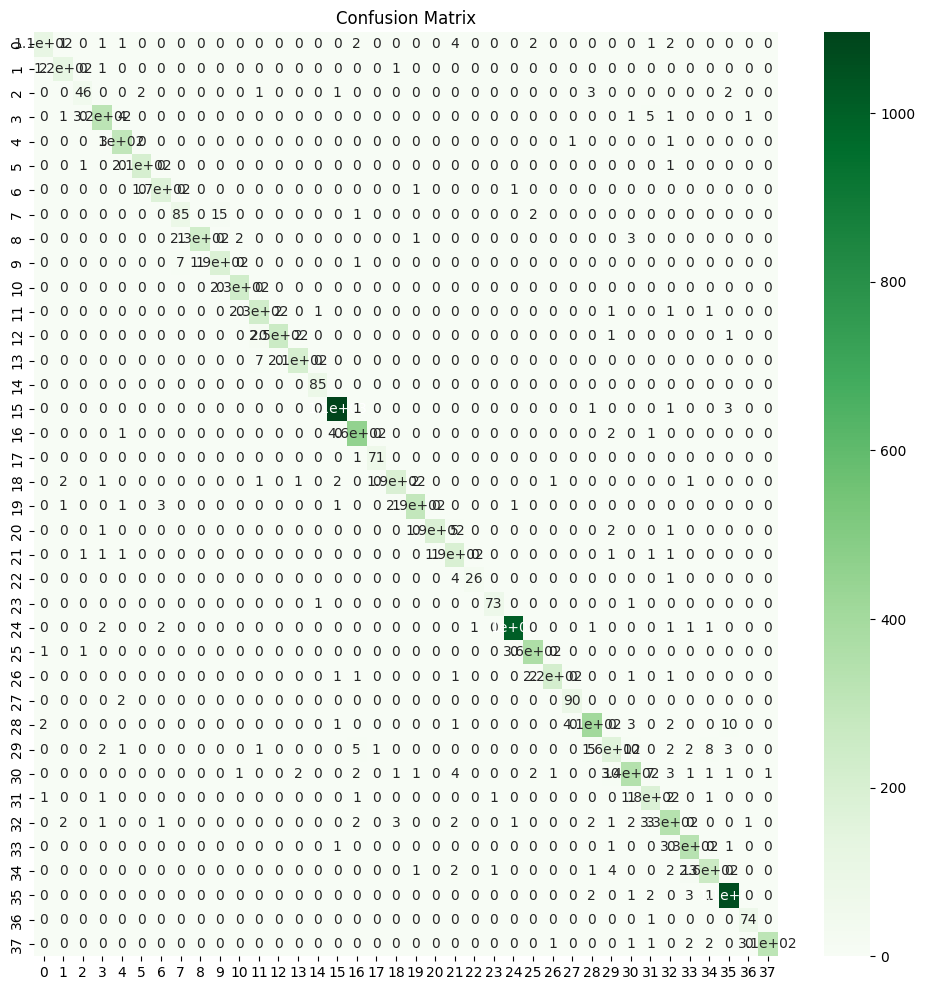

In [ ]:
report = classification_report(y_true,y_pred,target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report Table:\n")
print(report_df)

cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm,annot=True,cmap="Greens")
plt.title("Confusion Matrix")
plt.show()


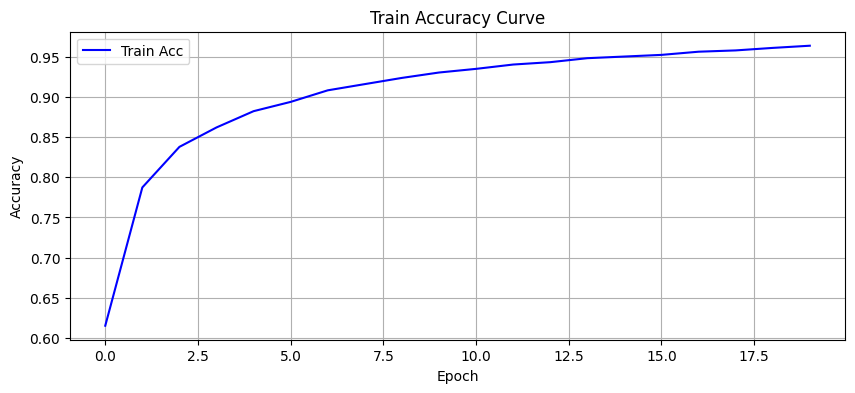

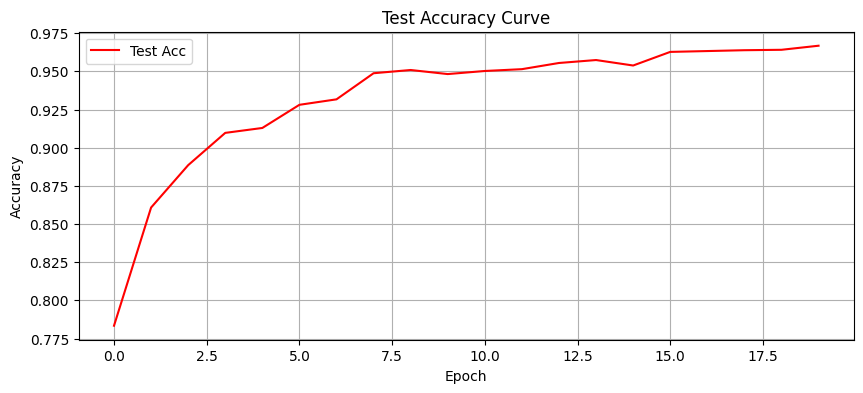

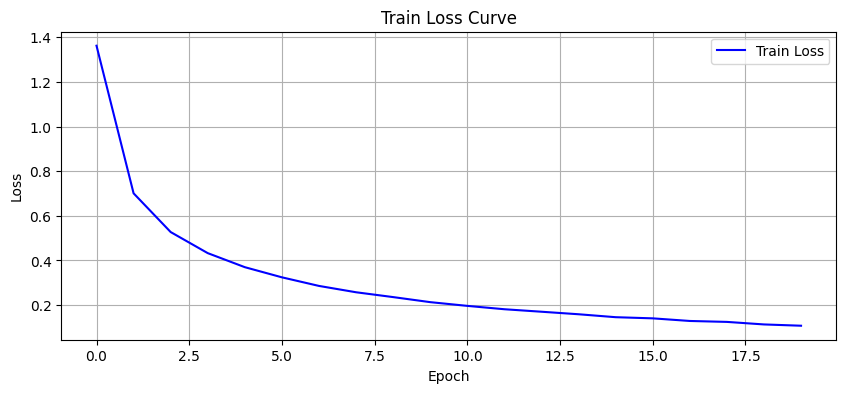

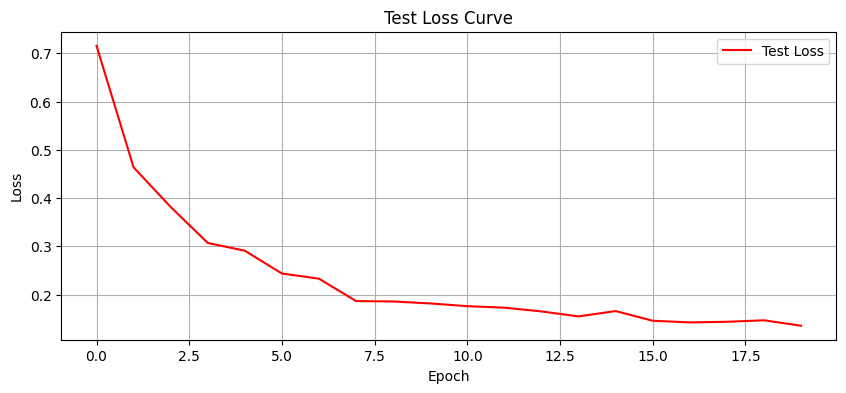

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(train_accs,label='Train Acc', color='blue')
plt.legend()
plt.title("Train Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
plt.plot(test_accs,label='Test Acc', color='red')
plt.legend()
plt.title("Test Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
plt.plot(train_losses,label='Train Loss', color='blue')
plt.legend()
plt.title("Train Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


plt.figure(figsize=(10,4))
plt.plot(test_losses,label='Test Loss', color='red')
plt.legend()
plt.title("Test Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
print("\nConfusion Matrix Metrics per Class (Tabular Form):")
num_classes = len(class_names)
total_samples = np.sum(cm)

metrics_data_tpfptn = []

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FP = np.sum(cm[:, i]) - TP
    FN = np.sum(cm[i, :]) - TP
    TN = total_samples - (TP + FP + FN)

    metrics_data_tpfptn.append({
        "Class": class_name,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN
    })

tpfptn_df = pd.DataFrame(metrics_data_tpfptn)
display(tpfptn_df)


Confusion Matrix Metrics per Class (Tabular Form):


,Class,TP,FP,FN,TN
0,Apple___Apple_scab,112,6,14,10744
1,Apple___Black_rot,121,7,4,10744
2,Apple___Cedar_apple_rust,46,3,9,10818
3,Apple___healthy,316,12,13,10535
4,Blueberry___healthy,298,11,3,10564
5,Cherry_(including_sour)___Powdery_mildew,209,2,2,10663
6,Cherry_(including_sour)___healthy,169,6,2,10699
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,85,8,18,10765
8,Corn_(maize)___Common_rust_,232,1,7,10636
9,Corn_(maize)___Northern_Leaf_Blight,188,15,9,10664


/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


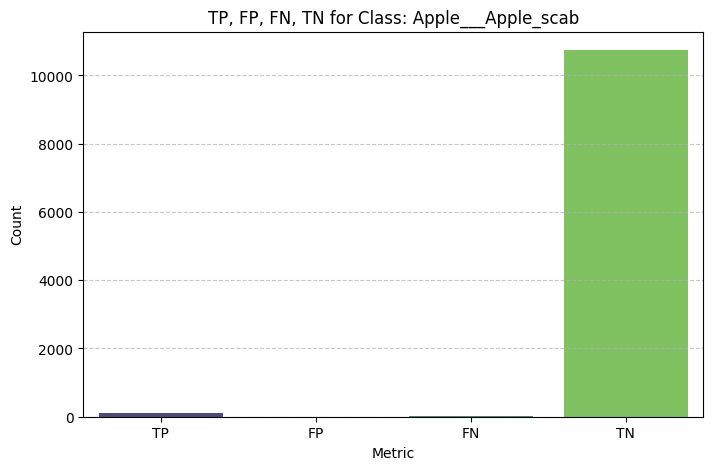

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


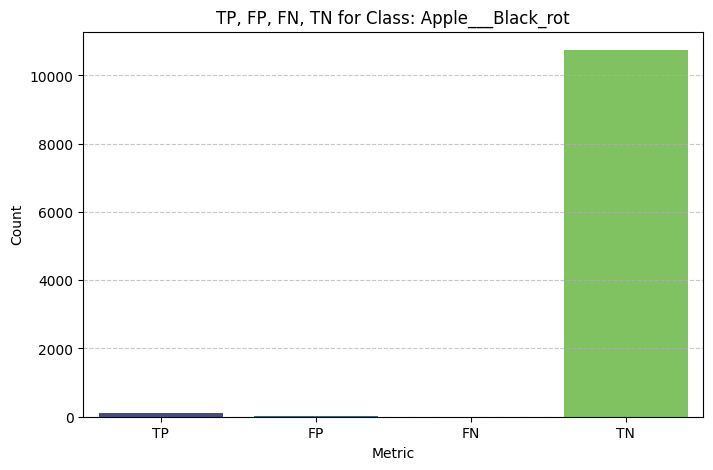

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


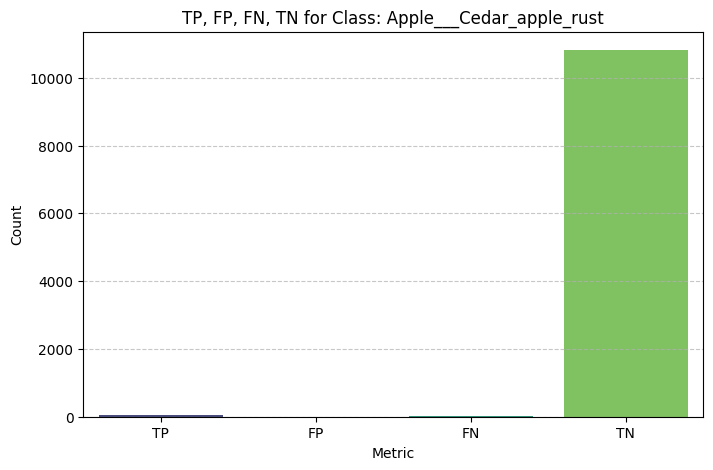

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


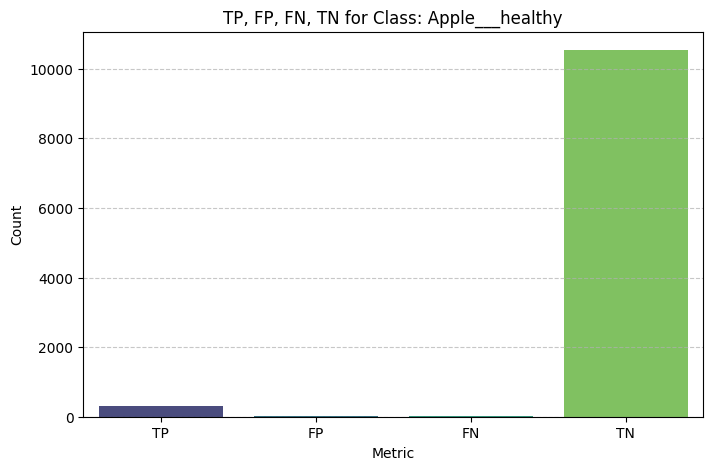

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


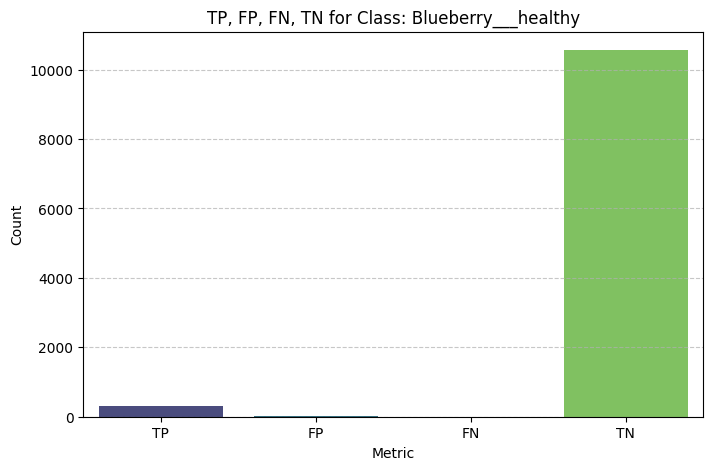

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


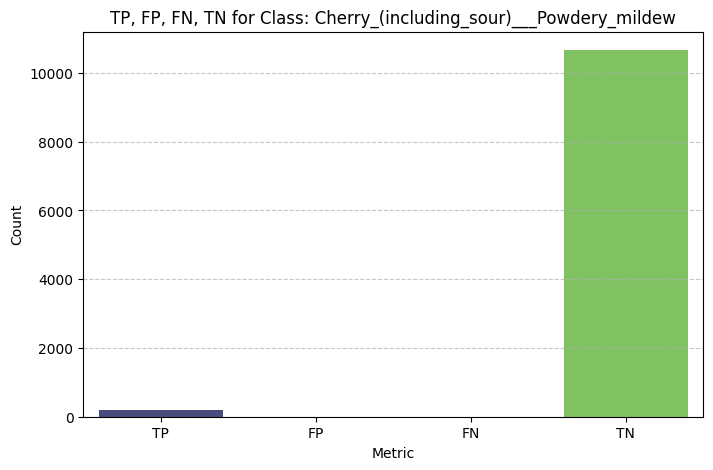

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


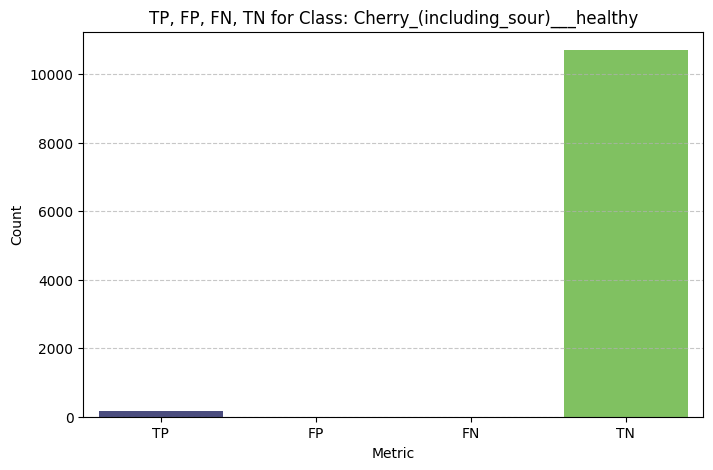

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


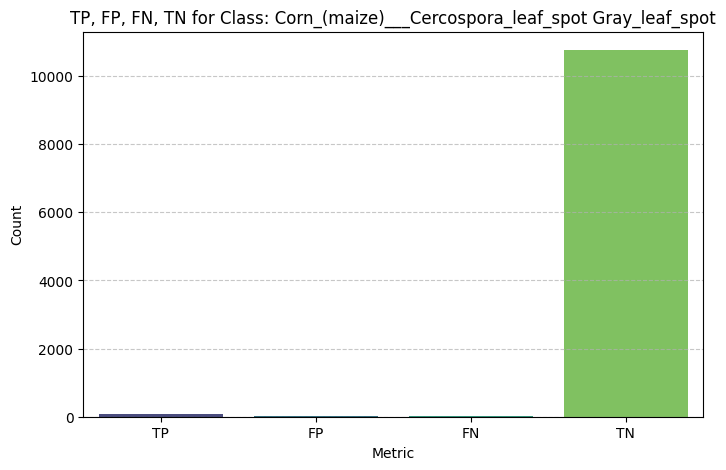

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


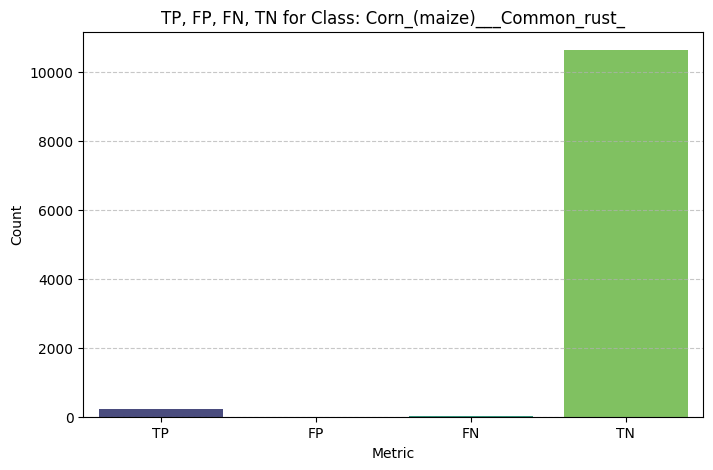

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


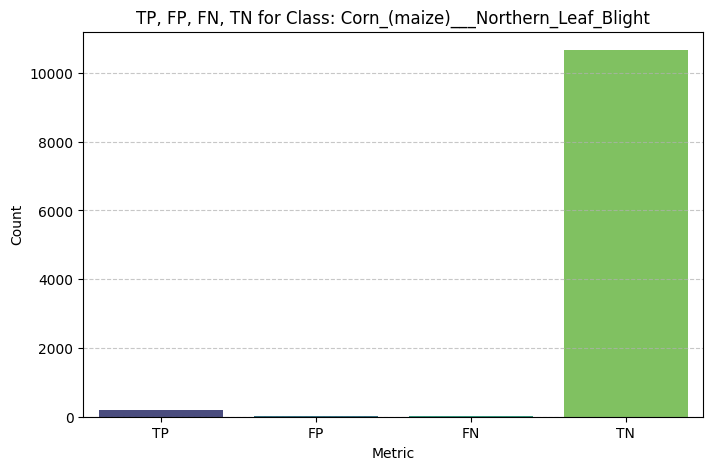

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


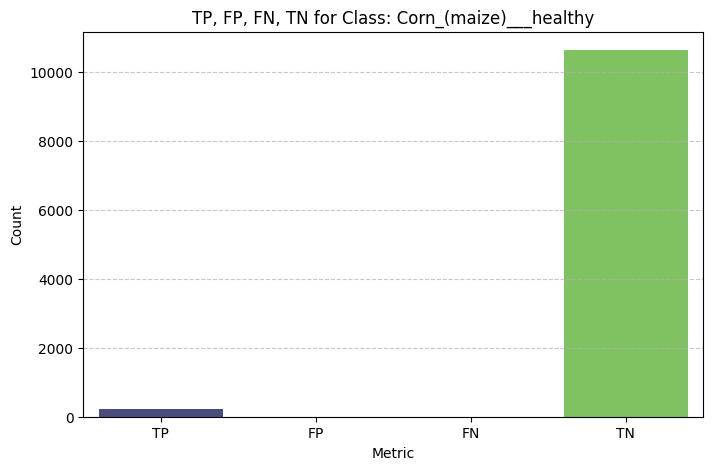

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


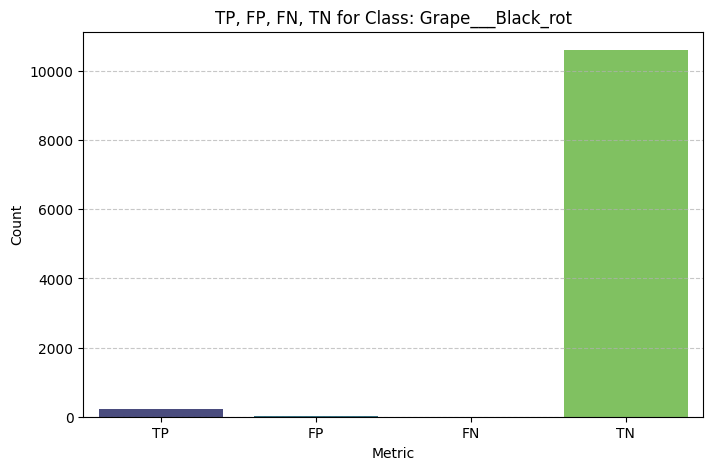

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


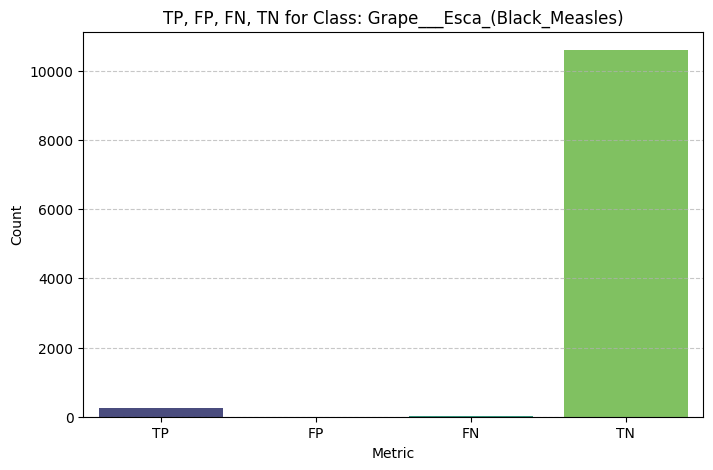

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


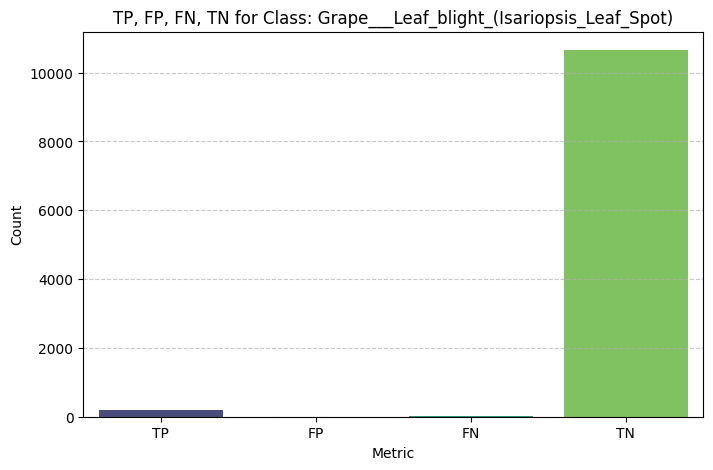

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


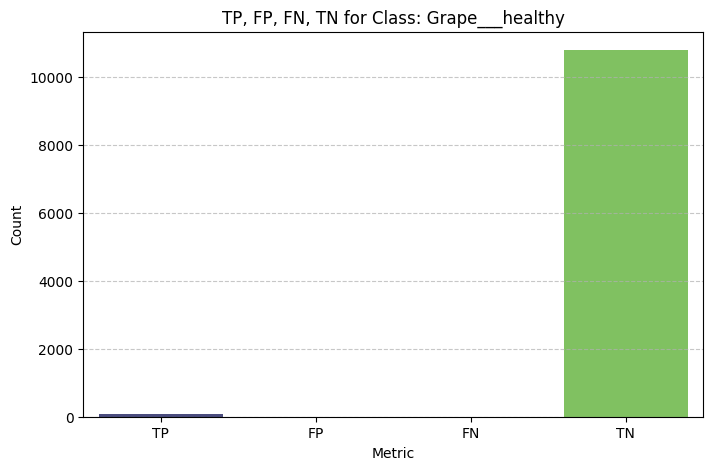

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


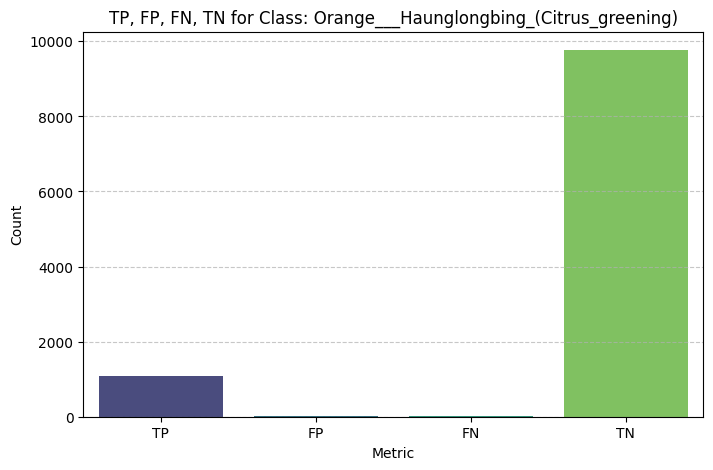

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


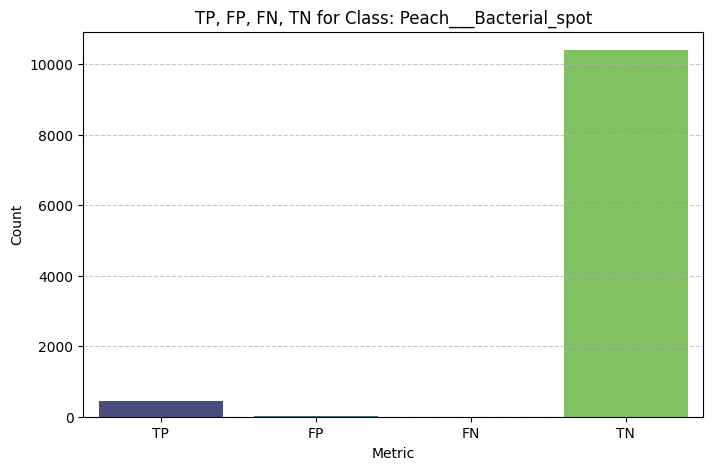

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


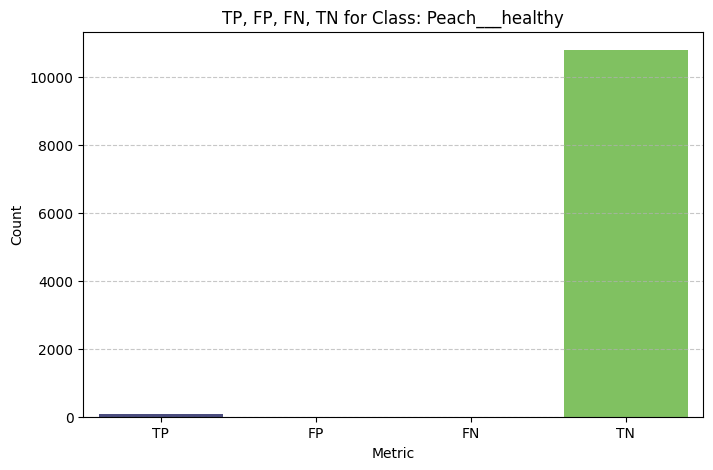

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


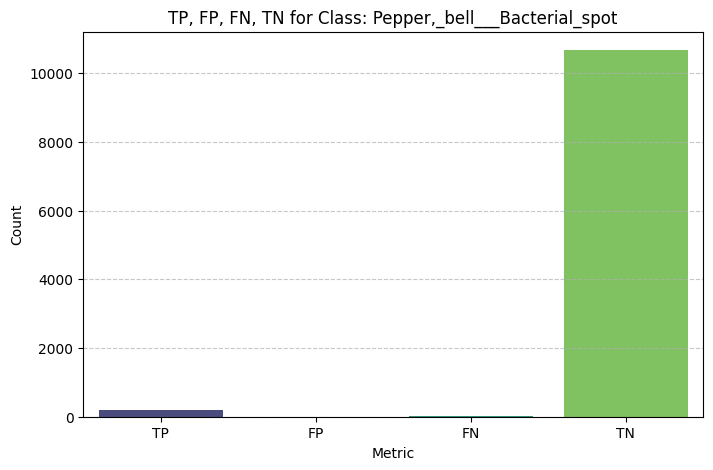

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


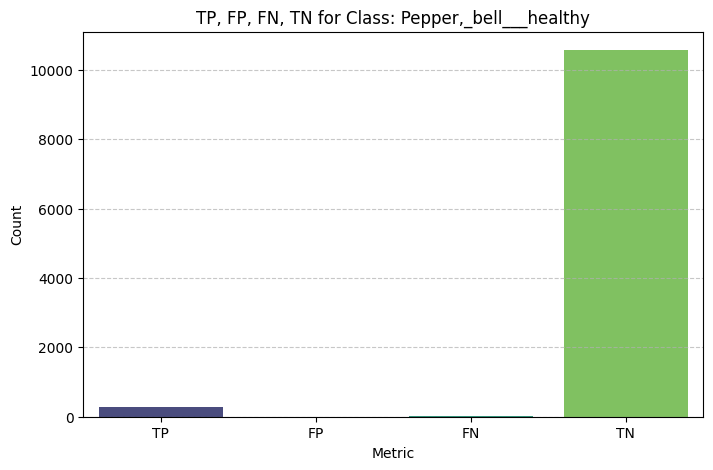

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


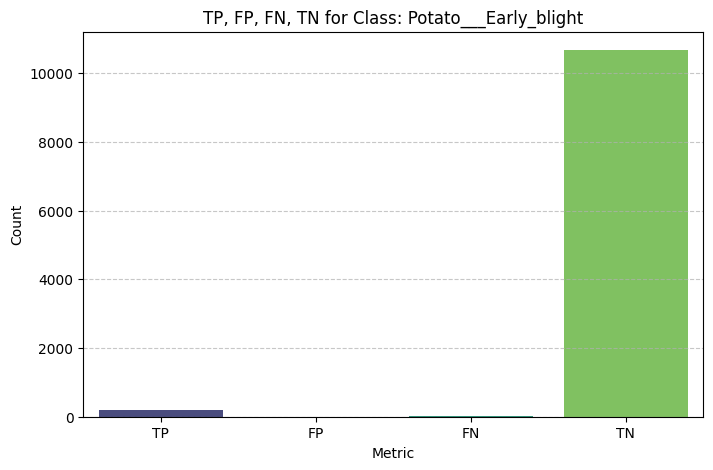

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


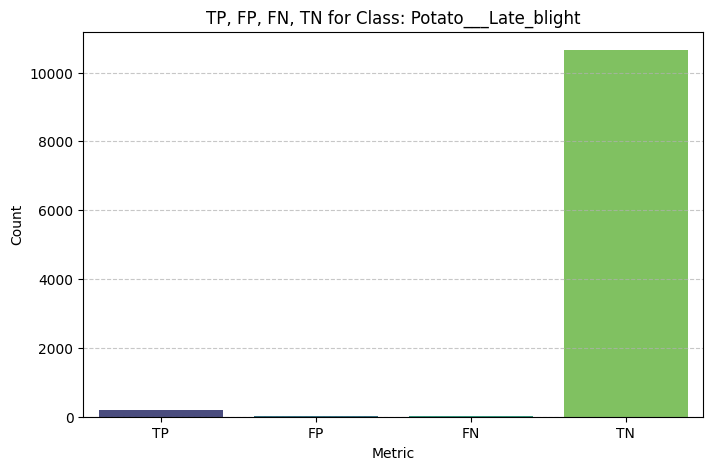

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


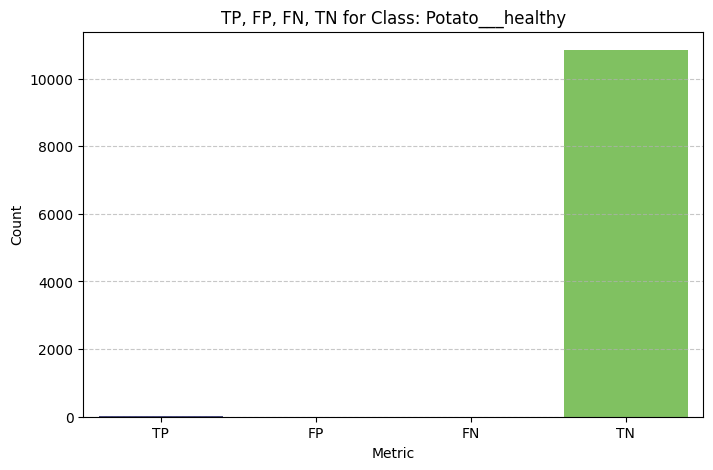

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


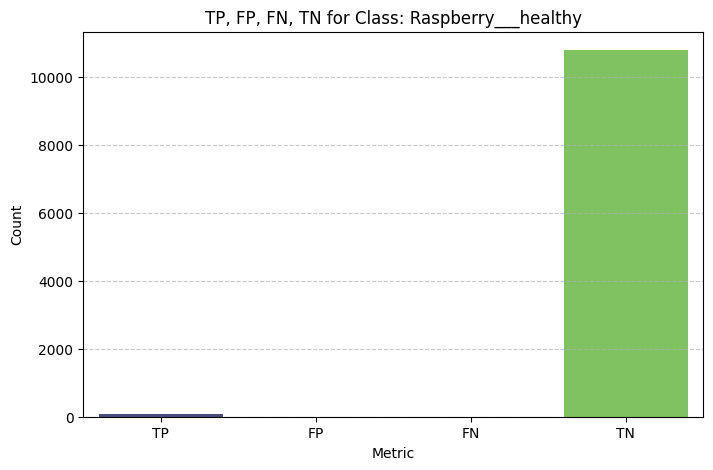

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


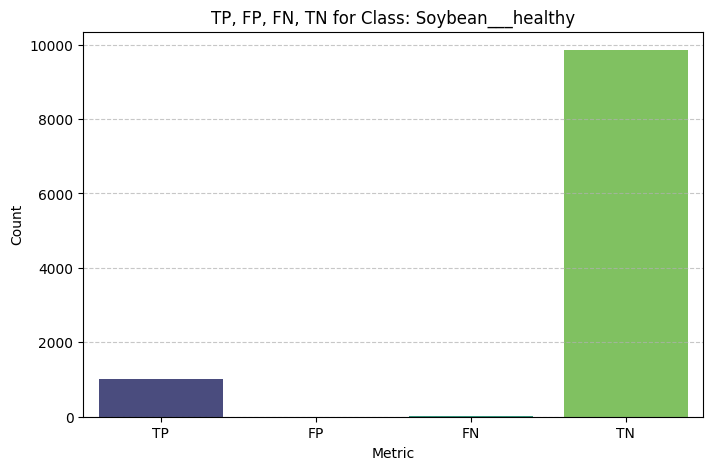

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


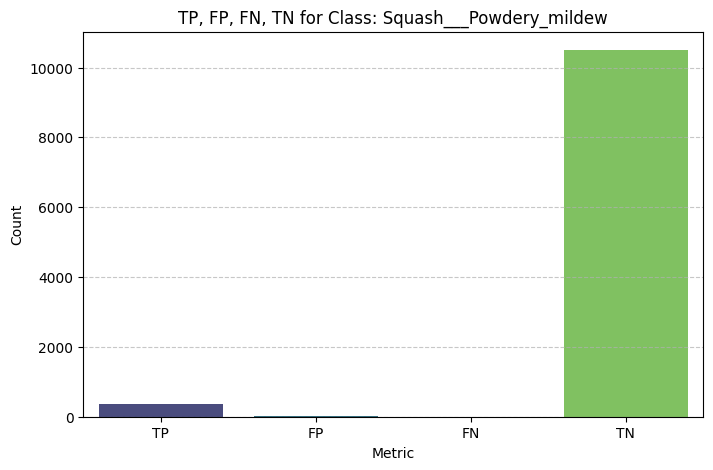

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


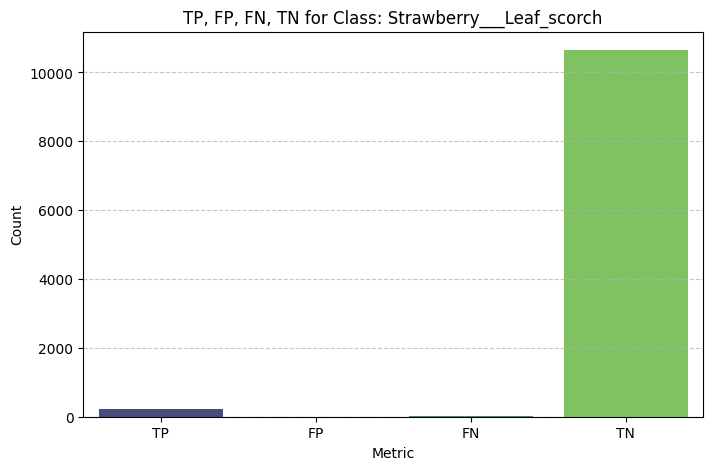

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


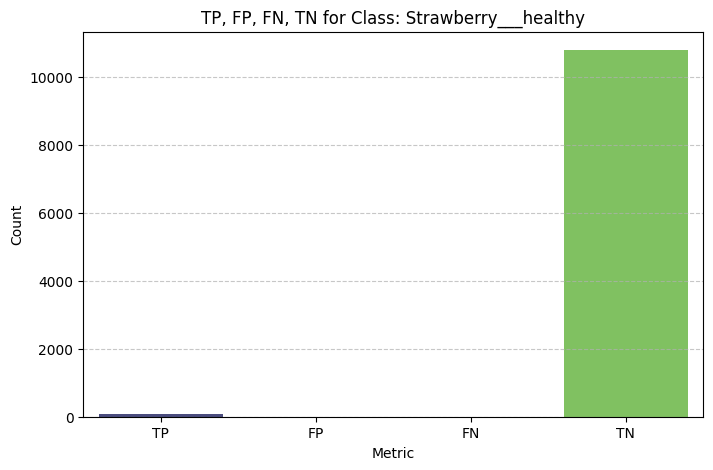

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


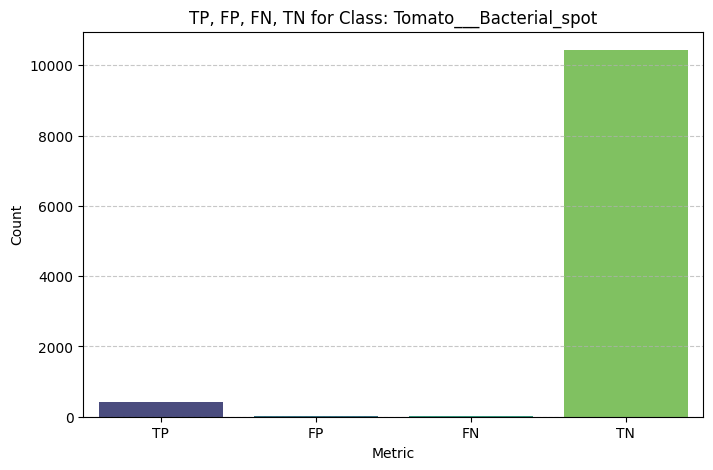

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


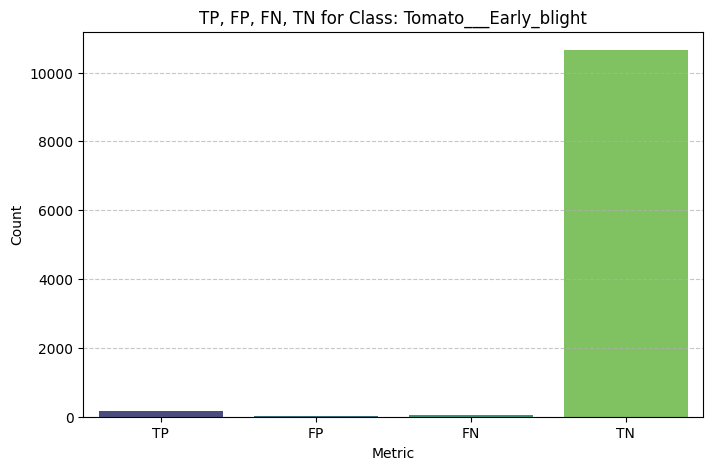

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


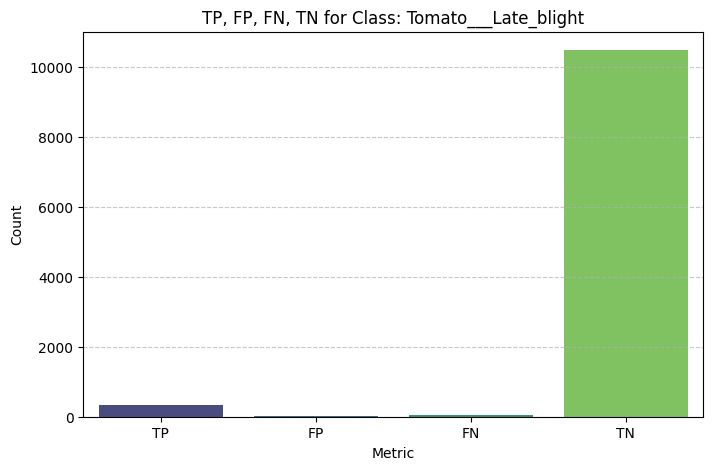

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


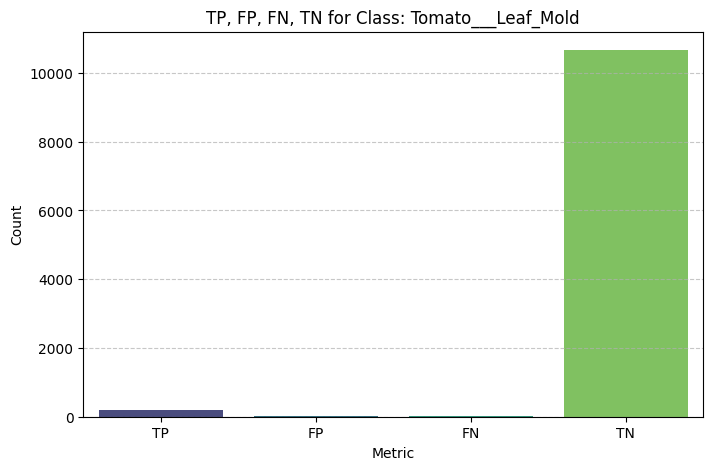

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


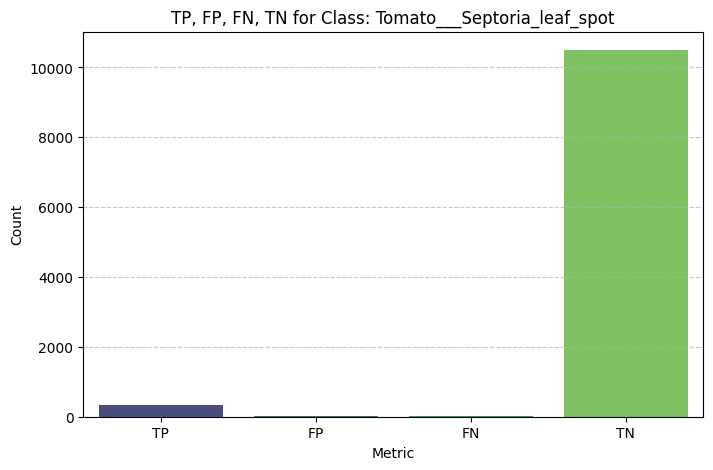

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


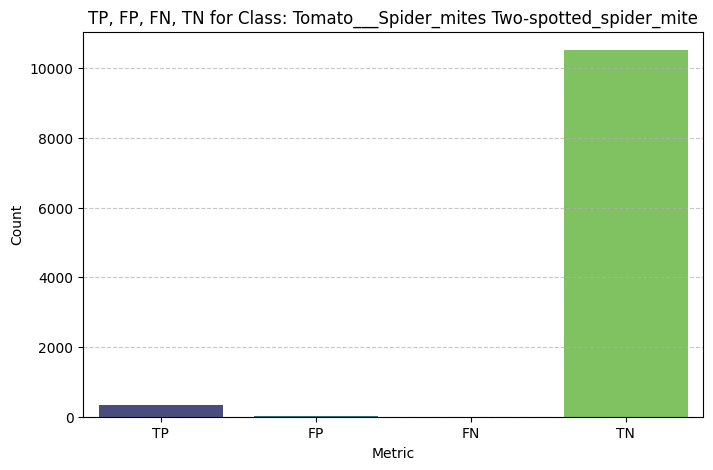

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


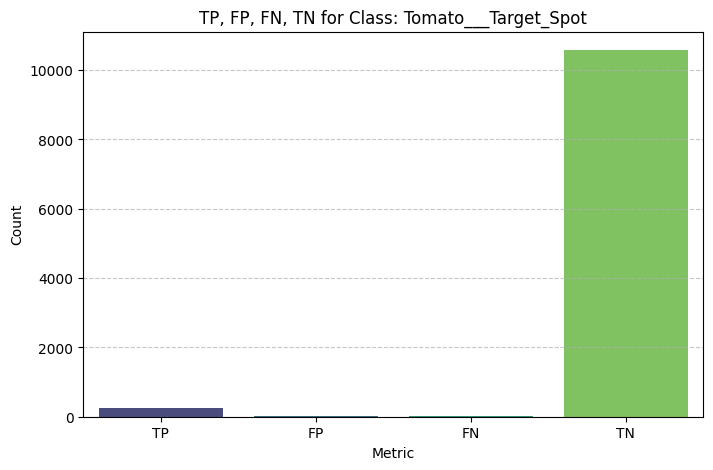

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


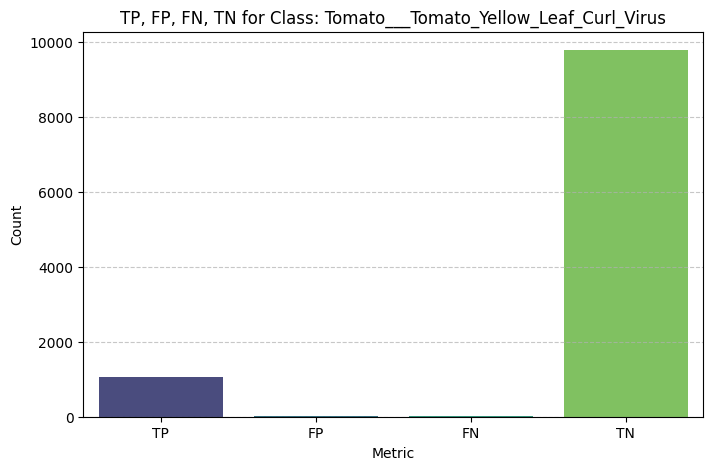

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


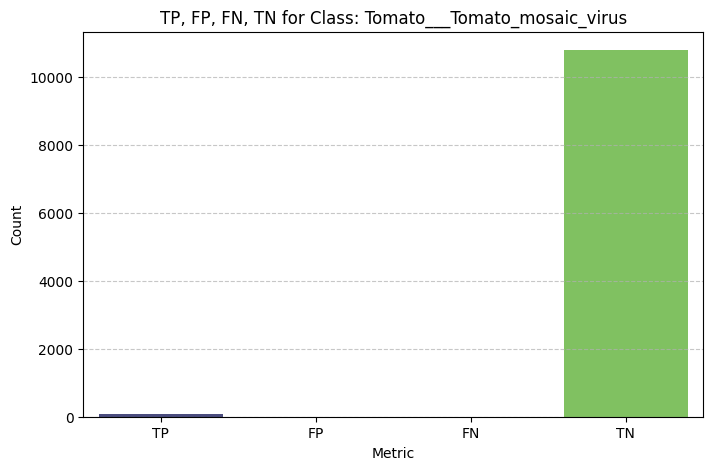

/tmp/ipython-input-6549166.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_to_plot, y=values, palette='viridis')


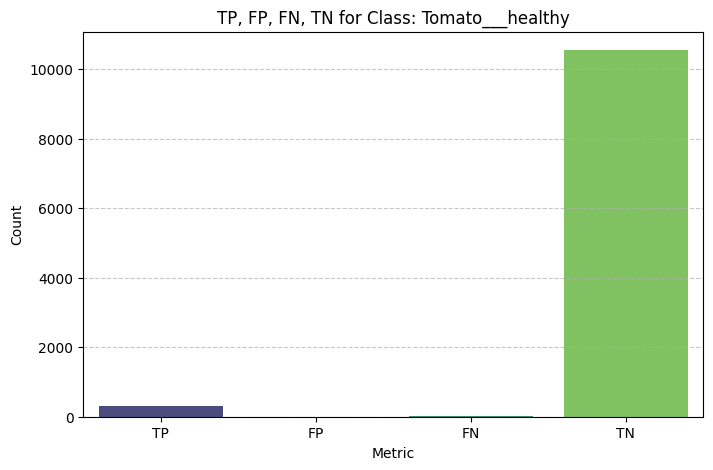

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics_to_plot = ['TP', 'FP', 'FN', 'TN']

for index, row in tpfptn_df.iterrows():
    class_name = row['Class']
    values = [row[metric] for metric in metrics_to_plot]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=metrics_to_plot, y=values, palette='viridis')
    plt.title(f'TP, FP, FN, TN for Class: {class_name}')
    plt.ylabel('Count')
    plt.xlabel('Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
simplified_class_names = [f'c{i+1}' for i in range(len(class_names))]
cm_df = pd.DataFrame(cm, index=simplified_class_names, columns=simplified_class_names)
print("\nConfusion Matrix (Tabular Form):\n")
display(cm_df)


Confusion Matrix (Tabular Form):



,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38
c1,112,1,0,1,1,0,0,0,0,0,...,0,0,0,1,2,0,0,0,0,0
c2,2,121,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c3,0,0,46,0,0,2,0,0,0,0,...,3,0,0,0,0,0,0,2,0,0
c4,0,1,0,316,4,0,0,0,0,0,...,0,0,1,5,1,0,0,0,1,0
c5,0,0,0,1,298,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
c6,0,0,1,0,0,209,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
c7,0,0,0,0,0,0,169,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c8,0,0,0,0,0,0,0,85,0,15,...,0,0,0,0,0,0,0,0,0,0
c9,0,0,0,0,0,0,0,1,232,0,...,0,0,3,0,0,0,0,0,0,0
c10,0,0,0,0,0,0,0,7,1,188,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

output_dir = '/content/drive/MyDrive/plantvillage_analysis_results'
os.makedirs(output_dir, exist_ok=True)


fig, ax = plt.subplots(figsize=(16, 12))
ax.axis('off')
ax.table(cellText=cm_df.values, colLabels=cm_df.columns, rowLabels=cm_df.index, loc='center', cellLoc='center')
ax.set_title('Confusion Matrix (Tabular Form)', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'confusion_matrix_table.png'), bbox_inches='tight')
plt.close(fig)
print(f"Confusion matrix table saved as '{os.path.join(output_dir, 'confusion_matrix_table.png')}'")

Confusion matrix table saved as '/content/drive/MyDrive/plantvillage_analysis_results/confusion_matrix_table.png'


In [ ]:
import os

output_dir = '/content/drive/MyDrive/plantvillage_analysis_results'
os.makedirs(output_dir, exist_ok=True)

cm_df.to_excel(os.path.join(output_dir, 'confusion_matrix.xlsx'), index=True)
print(f"Confusion matrix table saved to '{os.path.join(output_dir, 'confusion_matrix.xlsx')}'")

Confusion matrix table saved to '/content/drive/MyDrive/plantvillage_analysis_results/confusion_matrix.xlsx'


In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
import pandas as pd

metrics_data = []
print("\nMetrics per Class:")
for i, class_name in enumerate(class_names):

    true_labels_for_class = [1 if label == i else 0 for label in y_true]
    pred_labels_for_class = [1 if label == i else 0 for label in y_pred]


    precision = precision_score(true_labels_for_class, pred_labels_for_class, zero_division=0)
    recall = recall_score(true_labels_for_class, pred_labels_for_class, zero_division=0)
    f1 = f1_score(true_labels_for_class, pred_labels_for_class, zero_division=0)

    metrics_data.append({
        "Class": class_name,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)
print("-" * 30)


Metrics per Class:


,Class,Precision,Recall,F1-Score
0,Apple___Apple_scab,0.949153,0.888889,0.918033
1,Apple___Black_rot,0.945312,0.968000,0.956522
2,Apple___Cedar_apple_rust,0.938776,0.836364,0.884615
3,Apple___healthy,0.963415,0.960486,0.961948
4,Blueberry___healthy,0.964401,0.990033,0.977049
5,Cherry_(including_sour)___Powdery_mildew,0.990521,0.990521,0.990521
6,Cherry_(including_sour)___healthy,0.965714,0.988304,0.976879
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0.913978,0.825243,0.867347
8,Corn_(maize)___Common_rust_,0.995708,0.970711,0.983051
9,Corn_(maize)___Northern_Leaf_Blight,0.926108,0.954315,0.940000


------------------------------


In [ ]:
import os

output_dir = '/content/drive/MyDrive/plantvillage_analysis_results'
os.makedirs(output_dir, exist_ok=True)

metrics_df.to_excel(os.path.join(output_dir, 'class_metrics.xlsx'), index=False)
print(f"Class metrics table saved to '{os.path.join(output_dir, 'class_metrics.xlsx')}'")

Class metrics table saved to '/content/drive/MyDrive/plantvillage_analysis_results/class_metrics.xlsx'


In [ ]:
import os

output_dir = '/content/drive/MyDrive/plantvillage_analysis_results'
os.makedirs(output_dir, exist_ok=True)

metrics_df.to_csv(os.path.join(output_dir, 'class_metrics.csv'), index=False)
print(f"Class metrics table saved to '{os.path.join(output_dir, 'class_metrics.csv')}'")

Class metrics table saved to '/content/drive/MyDrive/plantvillage_analysis_results/class_metrics.csv'


In [ ]:
import os

output_dir = '/content/drive/MyDrive/plantvillage_analysis_results'
os.makedirs(output_dir, exist_ok=True)

new_filename_prefix = 'metrics_table_updated'


metrics_df.to_csv(os.path.join(output_dir, f'{new_filename_prefix}.csv'), index=False)
print(f"Class metrics table saved to '{os.path.join(output_dir, f'{new_filename_prefix}.csv')}'")


metrics_df.to_excel(os.path.join(output_dir, f'{new_filename_prefix}.xlsx'), index=False)
print(f"Class metrics table saved to '{os.path.join(output_dir, f'{new_filename_prefix}.xlsx')}'")

Class metrics table saved to '/content/drive/MyDrive/plantvillage_analysis_results/metrics_table_updated.csv'
Class metrics table saved to '/content/drive/MyDrive/plantvillage_analysis_results/metrics_table_updated.xlsx'


In [ ]:
import torch
import os

output_dir = '/content/drive/MyDrive/plantvillage_analysis_results'
os.makedirs(output_dir, exist_ok=True)

model_save_path = os.path.join(output_dir, 'patch_based_leaf_net_model.pth')

torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to: {model_save_path}")

Model saved successfully to: /content/drive/MyDrive/plantvillage_analysis_results/patch_based_leaf_net_model.pth
